In [1]:
!pip install super-gradients

In [2]:
!pip install datasets roboflow pybboxes pillow pyyaml scikit-learn

In [40]:
import torch
import os
import shutil
import zipfile
import json
import random
import yaml
from PIL import Image
from roboflow import Roboflow
from sklearn.model_selection import train_test_split
import pybboxes as pbx
import glob
from collections import defaultdict
import matplotlib.pyplot as plt
from getpass import getpass

from super_gradients.training import dataloaders
from super_gradients.training.dataloaders.dataloaders import coco_detection_yolo_format_train, coco_detection_yolo_format_val
from super_gradients.training import models


from super_gradients.training.losses import PPYoloELoss
from super_gradients.training.metrics import DetectionMetrics_050
from super_gradients.training.models.detection_models.pp_yolo_e import PPYoloEPostPredictionCallback
from super_gradients.training import Trainer

from IPython.display import clear_output


In [41]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [4]:
base_dir = '/content/YoloNAS_Project/'
os.makedirs(base_dir, exist_ok=True)

In [43]:
CHECKPOINT_DIR = 'checkpoints'
trainer = Trainer(experiment_name='my_first_yolonas_run', ckpt_root_dir=CHECKPOINT_DIR)

In [5]:
def download_huggingface_dataset(save_dir):
    """
    Downloads the Hugging Face dataset and organizes it into images and labels directories.
    """
    os.makedirs(save_dir, exist_ok=True)

    # Load the dataset
    ds = load_dataset("keremberke/forklift-object-detection", name="full")

    # Create directories for each split
    for split in ds.keys():
        split_path = os.path.join(save_dir, split)
        images_path = os.path.join(split_path, 'images')
        labels_path = os.path.join(split_path, 'labels')
        os.makedirs(images_path, exist_ok=True)
        os.makedirs(labels_path, exist_ok=True)

        # Process each example in the split
        for example in ds[split]:
            # Download and save the image
            image_url = example['image']
            image_filename = os.path.basename(image_url)
            image_path = os.path.join(images_path, image_filename)
            if not os.path.exists(image_path):
                !wget -q {image_url} -O {image_path}

            # Save annotations
            annotation_filename = os.path.splitext(image_filename)[0] + '.txt'
            label_path = os.path.join(labels_path, annotation_filename)
            with open(label_path, 'w') as f:
                for obj in example['objects']:
                    class_id = obj['category_id'] - 1  # Assuming category_id starts at 1
                    bbox = obj['bbox']  # [x, y, width, height]
                    # YOLO format requires normalized coordinates, which we'll handle later
                    f.write(f"{class_id} {bbox[0]} {bbox[1]} {bbox[2]} {bbox[3]}\n")

    print(f"Hugging Face dataset downloaded and saved to {save_dir}")

In [ ]:
# # Define the path to save the Hugging Face dataset
# hf_save_dir = os.path.join(base_dir, 'huggingface_forklift')
# download_huggingface_dataset(hf_save_dir)

## Roboflow dataset

In [5]:
def download_roboflow_datasets(api_key, save_dir):
    """
    Downloads multiple Roboflow datasets and organizes them into separate directories.
    """
    rf = Roboflow(api_key=api_key)

    # Define datasets to download
    roboflow_datasets = [
        {
            "workspace": "hitsz",
            "project": "forklift-and-human",
            "version": "2"  # Changed to version 2 as per your working code
        },
        {
            "workspace": "paft",
            "project": "forklift-model",
            "version": "1"
        },
        {
            "workspace": "uqtr-2v1ej",
            "project": "forklift-9rs9h",
            "version": "1"
        }
    ]

    # Iterate over each dataset and download
    for ds_info in roboflow_datasets:
        workspace = ds_info["workspace"]
        project = ds_info["project"]
        version = ds_info["version"]

        print(f"Downloading Roboflow dataset: {workspace}/{project}/v{version}")
        project_rf = rf.workspace(workspace).project(project)
        dataset = project_rf.version(int(version)).download("yolov5")  # Ensure version is an integer

        # Move dataset to specific folder
        destination = os.path.join(save_dir, f"{project}_v{version}")
        os.makedirs(destination, exist_ok=True)
        for item in os.listdir(dataset.location):
            s = os.path.join(dataset.location, item)
            d = os.path.join(destination, item)
            if os.path.isdir(s):
                shutil.move(s, d)
            else:
                shutil.move(s, d)

    print(f"All Roboflow datasets downloaded and saved to {save_dir}")

In [6]:
def extract_zip_datasets(rf_dir):
    """
    Extracts all .zip files within the Roboflow directory.
    """
    zip_files = glob.glob(os.path.join(rf_dir, '*', '*.zip'))
    for zip_file in zip_files:
        print(f"Extracting {zip_file}")
        with zipfile.ZipFile(zip_file, 'r') as zip_ref:
            # Extract to the same directory as the zip file
            extract_path = os.path.splitext(zip_file)[0]
            zip_ref.extractall(extract_path)
        print(f"Extracted to {extract_path}")

        # Optionally, remove the zip file after extraction
        os.remove(zip_file)
        print(f"Removed zip file: {zip_file}")

In [23]:
def merge_datasets(rf_dir, merged_dir):
    """
    Merges multiple Roboflow datasets into unified train, valid, and test directories.

    Parameters:
    - rf_dir (str): Directory containing individual datasets.
    - merged_dir (str): Directory where the merged dataset will be stored.

    Returns:
    - None
    """
    splits = ['train', 'valid', 'test']
    image_splits = {split: os.path.join(merged_dir, 'images', split) for split in splits}
    label_splits = {split: os.path.join(merged_dir, 'labels', split) for split in splits}

    # Create merged directory structure
    for path in list(image_splits.values()) + list(label_splits.values()):
        os.makedirs(path, exist_ok=True)

    # Iterate through each dataset in rf_dir
    for dataset in os.listdir(rf_dir):
        dataset_path = os.path.join(rf_dir, dataset)
        if not os.path.isdir(dataset_path):
            continue  # Skip if not a directory

        print(f"Merging dataset: {dataset}")

        for split in splits:
            # Define source paths based on the correct directory structure
            src_images = os.path.join(dataset_path, split, 'images')
            src_labels = os.path.join(dataset_path, split, 'labels')

            # Check if source directories exist
            if not os.path.exists(src_images):
                print(f"Warning: {src_images} does not exist. Skipping.")
                continue
            if not os.path.exists(src_labels):
                print(f"Warning: {src_labels} does not exist. Skipping.")
                continue

            # Define destination paths
            dest_images = image_splits[split]
            dest_labels = label_splits[split]

            # Copy images
            for img_file in os.listdir(src_images):
                if img_file.lower().endswith(('.jpg', '.jpeg', '.png')):
                    src_img_path = os.path.join(src_images, img_file)
                    dest_img_path = os.path.join(dest_images, img_file)
                    if not os.path.exists(dest_img_path):
                        shutil.copy2(src_img_path, dest_img_path)

            # Copy labels
            for label_file in os.listdir(src_labels):
                if label_file.lower().endswith('.txt'):
                    src_label_path = os.path.join(src_labels, label_file)
                    dest_label_path = os.path.join(dest_labels, label_file)
                    if not os.path.exists(dest_label_path):
                        shutil.copy2(src_label_path, dest_label_path)

    print(f"All datasets have been merged into {merged_dir}")

In [24]:
def create_dataset_yaml(merged_dir, yaml_output_path, classes):
    """
    Creates a dataset.yaml file for YOLO-NAS.

    Parameters:
    - merged_dir (str): The directory where the merged dataset resides.
    - yaml_output_path (str): The path where the YAML file will be saved.
    - classes (list): List of class names.

    Returns:
    - None
    """
    dataset_yaml = {
        'train': os.path.join(merged_dir, 'images', 'train'),
        'val': os.path.join(merged_dir, 'images', 'valid'),
        'test': os.path.join(merged_dir, 'images', 'test'),  # Optional
        'nc': len(classes),
        'names': classes
    }

    with open(yaml_output_path, 'w') as f:
        yaml.dump(dataset_yaml, f)

    print(f"dataset.yaml has been created at {yaml_output_path}")

def count_instances(merged_labels_dir, classes):
    """
    Counts the number of instances per class in each split.

    Parameters:
    - merged_labels_dir (str): Directory containing label files organized by split.
    - classes (list): List of class names.

    Returns:
    - stats (dict): Nested dictionary with counts per split and per class.
    """
    stats = {
        'train': defaultdict(int),
        'valid': defaultdict(int),
        'test': defaultdict(int)
    }

    splits = ['train', 'valid', 'test']

    for split in splits:
        split_labels_dir = os.path.join(merged_labels_dir, split)
        if not os.path.exists(split_labels_dir):
            print(f"Warning: {split_labels_dir} does not exist.")
            continue
        for label_file in os.listdir(split_labels_dir):
            if label_file.lower().endswith('.txt'):
                label_path = os.path.join(split_labels_dir, label_file)
                with open(label_path, 'r') as lf:
                    lines = lf.readlines()
                for line in lines:
                    parts = line.strip().split()
                    if len(parts) < 5:
                        continue  # Invalid label format
                    class_id = int(parts[0])
                    if class_id < len(classes):
                        class_name = classes[class_id]
                        stats[split][class_name] += 1
                    else:
                        class_name = "Unknown"
                        stats[split][class_name] += 1

    return stats

def display_statistics(stats):
    """
    Displays the count of instances per class in each split.

    Parameters:
    - stats (dict): Nested dictionary with counts per split and per class.

    Returns:
    - None
    """
    for split in ['train', 'valid', 'test']:
        print(f"\n--- {split.capitalize()} Set ---")
        total = sum(stats[split].values())
        print(f"Total Instances: {total}")
        for class_name, count in stats[split].items():
            print(f" - {class_name}: {count}")

In [8]:
roboflow_api_key = getpass('Enter your Roboflow API Key: ')

# Define the path to save Roboflow datasets
rf_save_dir = os.path.join(base_dir, 'roboflow')
os.makedirs(rf_save_dir, exist_ok=True)

# Download Roboflow datasets
download_roboflow_datasets(roboflow_api_key, rf_save_dir)

# Extract all zip files in the Roboflow directory
extract_zip_datasets(rf_save_dir)


Enter your Roboflow API Key: ··········
loading Roboflow workspace...
loading Roboflow project...


Extracting Dataset Version Zip to Forklift-and-Human-2 in yolov5pytorch::  10%|█         | 398/3910 [00:00<00:00, 3976.97it/s]

Extracting Dataset Version Zip to Forklift-and-Human-2 in yolov5pytorch:: 100%|██████████| 3910/3910 [00:01<00:00, 2399.68it/s]


loading Roboflow workspace...
loading Roboflow project...


Extracting Dataset Version Zip to Forklift-Model-1 in yolov5pytorch::   0%|          | 0/3001 [00:00<?, ?it/s]

Extracting Dataset Version Zip to Forklift-Model-1 in yolov5pytorch:: 100%|██████████| 3001/3001 [00:00<00:00, 3939.44it/s]


loading Roboflow workspace...
loading Roboflow project...


Extracting Dataset Version Zip to Forklift-1 in yolov5pytorch::  13%|█▎        | 341/2670 [00:00<00:00, 3382.93it/s]

Extracting Dataset Version Zip to Forklift-1 in yolov5pytorch:: 100%|██████████| 2670/2670 [00:00<00:00, 3048.70it/s]


All Roboflow datasets downloaded and saved to /content/YoloNAS_Project/roboflow


In [25]:
!rm -r /content/YoloNAS_Project/merged_dataset

In [26]:
rf_save_dir = '/content/YoloNAS_Project/roboflow'
merged_dataset_dir = '/content/YoloNAS_Project/merged_dataset'

merge_datasets(rf_dir=rf_save_dir, merged_dir=merged_dataset_dir)

classes = ['forklift', 'person']
yaml_output_path = os.path.join(merged_dataset_dir, 'dataset.yaml')
create_dataset_yaml(merged_dir=merged_dataset_dir, yaml_output_path=yaml_output_path, classes=classes)


stats = count_instances(merged_labels_dir=os.path.join(merged_dataset_dir, 'labels'), classes=classes)
display_statistics(stats)

Merging dataset: forklift-and-human_v2
Merging dataset: forklift-9rs9h_v1
Merging dataset: forklift-model_v1
All datasets have been merged into /content/YoloNAS_Project/merged_dataset
dataset.yaml has been created at /content/YoloNAS_Project/merged_dataset/dataset.yaml

--- Train Set ---
Total Instances: 5238
 - person: 1381
 - forklift: 3857

--- Valid Set ---
Total Instances: 1572
 - forklift: 1157
 - person: 415

--- Test Set ---
Total Instances: 588
 - forklift: 418
 - person: 170


# Investigate dataset

In [27]:
dataset_params = {
    'data_dir': '/content/YoloNAS_Project/merged_dataset',
    'train_images_dir': 'images/train',
    'train_labels_dir': 'labels/train',
    'val_images_dir': 'images/valid',
    'val_labels_dir': 'labels/valid',
    'test_images_dir': 'images/test',
    'test_labels_dir': 'labels/test',
    'classes': ['forklift', 'person']
}

In [29]:
train_data = coco_detection_yolo_format_train(
    dataset_params={
        'data_dir': dataset_params['data_dir'],
        'images_dir': dataset_params['train_images_dir'],
        'labels_dir': dataset_params['train_labels_dir'],
        'classes': dataset_params['classes']
    },
    dataloader_params={
        'batch_size': 8,
        'num_workers': 2
    }
)


val_data = coco_detection_yolo_format_val(
    dataset_params={
        'data_dir': dataset_params['data_dir'],
        'images_dir': dataset_params['val_images_dir'],
        'labels_dir': dataset_params['val_labels_dir'],
        'classes': dataset_params['classes']
    },
    dataloader_params={
        'batch_size': 8,
        'num_workers': 2
    }
)


test_data = coco_detection_yolo_format_val(
    dataset_params={
        'data_dir': dataset_params['data_dir'],
        'images_dir': dataset_params['test_images_dir'],
        'labels_dir': dataset_params['test_labels_dir'],
        'classes': dataset_params['classes']
    },
    dataloader_params={
        'batch_size': 8,
        'num_workers': 2
    }
)

clear_output()

Transformations applied to training data:
[<super_gradients.training.transforms.transforms.DetectionMosaic object at 0x79785315bf70>, <super_gradients.training.transforms.transforms.DetectionRandomAffine object at 0x797852fec070>, <super_gradients.training.transforms.transforms.DetectionMixup object at 0x797852fec0a0>, <super_gradients.training.transforms.transforms.DetectionHSV object at 0x797852fec0d0>, <super_gradients.training.transforms.transforms.DetectionHorizontalFlip object at 0x797852fec160>, <super_gradients.training.transforms.transforms.DetectionPaddedRescale object at 0x797852fec1c0>, <super_gradients.training.transforms.transforms.DetectionTargetsFormatTransform object at 0x797852fec220>]

Visualizing samples from training data:


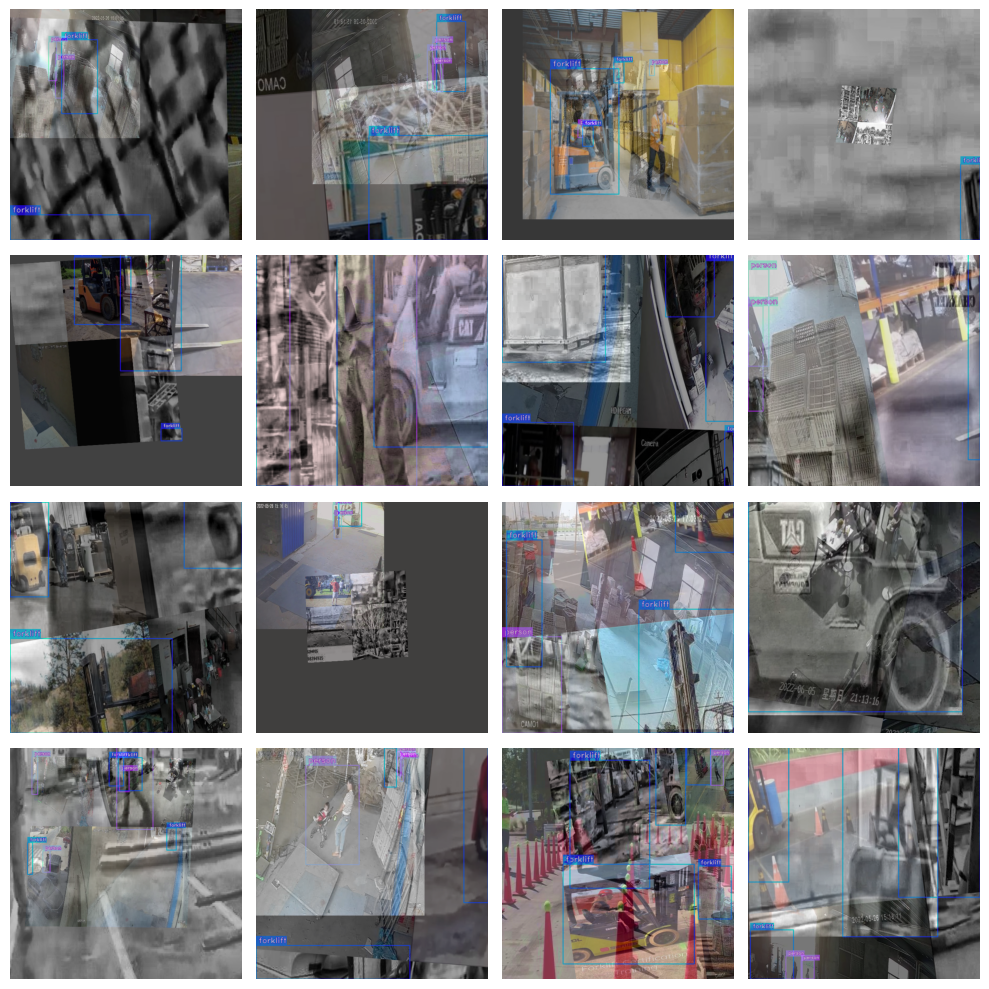

In [31]:
# Inspect Transformations Applied to Training Data
print("Transformations applied to training data:")
print(train_data.dataset.transforms)

# Visualize a Few Samples from Training Data
print("\nVisualizing samples from training data:")
train_data.dataset.plot()

# Model preparation

In [33]:
model = models.get('yolo_nas_s',
                   num_classes=len(dataset_params['classes']),
                   pretrained_weights="coco"
                   )

[2024-10-04 09:04:11] WARNING - checkpoint_utils.py - :warning: The pre-trained models provided by SuperGradients may have their own licenses or terms and conditions derived from the dataset used for pre-training.
 It is your responsibility to determine whether you have permission to use the models for your use case.
 The model you have requested was pre-trained on the coco dataset, published under the following terms: https://cocodataset.org/#termsofuse
[2024-10-04 09:04:11] INFO - checkpoint_utils.py - License Notification: YOLO-NAS pre-trained weights are subjected to the specific license terms and conditions detailed in 
https://github.com/Deci-AI/super-gradients/blob/master/LICENSE.YOLONAS.md
By downloading the pre-trained weight files you agree to comply with these terms.
Downloading: "https://sghub.deci.ai/models/yolo_nas_s_coco.pth" to /root/.cache/torch/hub/checkpoints/yolo_nas_s_coco.pth
100%|██████████| 73.1M/73.1M [00:03<00:00, 20.3MB/s]
[2024-10-04 09:04:16] INFO - checkpo

In [36]:
train_params = {
    # ENABLING SILENT MODE
    'silent_mode': False,
    "average_best_models":True,
    "warmup_mode": "linear_epoch_step",
    "warmup_initial_lr": 1e-6,
    "lr_warmup_epochs": 3,
    "initial_lr": 5e-4,
    "lr_mode": "cosine",
    "cosine_final_lr_ratio": 0.1,
    "optimizer": "Adam",
    "optimizer_params": {"weight_decay": 0.0001},
    "zero_weight_decay_on_bias_and_bn": True,
    "ema": True,
    "ema_params": {"decay": 0.9, "decay_type": "threshold"},
    # ONLY TRAINING FOR 10 EPOCHS FOR THIS EXAMPLE NOTEBOOK
    "max_epochs": 2,
    "mixed_precision": True,
    "loss": PPYoloELoss(
        use_static_assigner=False,
        # NOTE: num_classes needs to be defined here
        num_classes=len(dataset_params['classes']),
        reg_max=16
    ),
    "valid_metrics_list": [
        DetectionMetrics_050(
            score_thres=0.1,
            top_k_predictions=300,
            # NOTE: num_classes needs to be defined here
            num_cls=len(dataset_params['classes']),
            normalize_targets=True,
            post_prediction_callback=PPYoloEPostPredictionCallback(
                score_threshold=0.01,
                nms_top_k=1000,
                max_predictions=300,
                nms_threshold=0.7
            )
        )
    ],
    "metric_to_watch": 'mAP@0.50'
}


In [ ]:
trainer.train(model=model,
              training_params=train_params,
              train_loader=train_data,
              valid_loader=val_data)

[2024-10-04 09:09:38] INFO - sg_trainer.py - Starting a new run with `run_id=RUN_20241004_090938_877160`
[2024-10-04 09:09:38] INFO - sg_trainer.py - Checkpoints directory: checkpoints/my_first_yolonas_run/RUN_20241004_090938_877160


The console stream is now moved to checkpoints/my_first_yolonas_run/RUN_20241004_090938_877160/console_Oct04_09_09_38.txt


[2024-10-04 09:09:39] INFO - sg_trainer.py - Using EMA with params {'decay': 0.9, 'decay_type': 'threshold'}
Object name `linear_epoch_step` is now deprecated. Please replace it with `LinearEpochLRWarmup`.
initialize_param_groups and update_param_groups usages are deprecated since 3.4.0, will be removed in 3.5.0 and have no effect. 
 Assign different learning rates by passing a mapping of layer name prefixes to lr values through initial_lr training hyperparameter (i.e initial_lr={'backbone': 0.01, 'default':0.1})
Mixed precision training is not supported on CPU. Disabling mixed precision. (i.e. `mixed_precision=False`)
`torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
[2024-10-04 09:09:43] INFO - sg_trainer_utils.py - TRAINING PARAMETERS:
    - Mode:                         Single GPU
    - Number of GPUs:               0          (0 available on the machine)
    - Full dataset size:            3284       (len(train_set))
  

In [ ]:
checkpoints_base_dir = "/content/checkpoints/my_first_yolonas_run"
checkpoint_dirs = [d for d in os.listdir(checkpoints_base_dir) if os.path.isdir(os.path.join(checkpoints_base_dir, d))]
checkpoint_dirs.sort()
latest_checkpoint_dir = checkpoint_dirs[-1]

latest_checkpoint_path = os.path.join(checkpoints_base_dir, latest_checkpoint_dir, 'ckpt_best.pth')

In [ ]:
best_model = models.get('yolo_nas_s',
                        num_classes=len(dataset_params['classes']),
                        checkpoint_path=latest_checkpoint_path)

In [ ]:

trainer.test(model=best_model,
            test_loader=test_data,
            test_metrics_list=DetectionMetrics_050(score_thres=0.1,
                                                   top_k_predictions=300,
                                                   num_cls=len(dataset_params['classes']),
                                                   normalize_targets=True,
                                                   post_prediction_callback=PPYoloEPostPredictionCallback(score_threshold=0.01,
                                                                                                          nms_top_k=1000,
                                                                                                          max_predictions=300,
                                                                                                          nms_threshold=0.7)
                                                  ))


# Eval

In [ ]:
# def organize_datasets(rf_dir, merged_dir):
#     """
#     Merges multiple Roboflow datasets into a single directory with images and labels.
#     """
#     os.makedirs(merged_dir, exist_ok=True)
#     merged_images = os.path.join(merged_dir, 'images')
#     merged_labels = os.path.join(merged_dir, 'labels')
#     os.makedirs(merged_images, exist_ok=True)
#     os.makedirs(merged_labels, exist_ok=True)

#     # Function to copy files
#     def copy_files(src_images, src_labels):
#         for img_file in os.listdir(src_images):
#             if img_file.endswith(('.jpg', '.png', '.jpeg')):
#                 # Copy image
#                 src_img_path = os.path.join(src_images, img_file)
#                 dest_img_path = os.path.join(merged_images, img_file)
#                 if not os.path.exists(dest_img_path):
#                     shutil.copy(src_img_path, dest_img_path)

#                 # Copy label
#                 label_file = os.path.splitext(img_file)[0] + '.txt'
#                 src_label_path = os.path.join(src_labels, label_file)
#                 dest_label_path = os.path.join(merged_labels, label_file)
#                 if os.path.exists(src_label_path) and not os.path.exists(dest_label_path):
#                     shutil.copy(src_label_path, dest_label_path)

#     # Iterate over each Roboflow project
#     roboflow_projects = os.listdir(rf_dir)
#     for project in roboflow_projects:
#         project_dir = os.path.join(rf_dir, project)
#         for split in ['train', 'valid', 'test']:
#             split_dir = os.path.join(project_dir, split)
#             if os.path.exists(split_dir):
#                 src_images = os.path.join(split_dir, 'images')
#                 src_labels = os.path.join(split_dir, 'labels')
#                 copy_files(src_images, src_labels)

#     print(f"Datasets merged and saved to {merged_dir}")

In [ ]:
# Define merged dataset directory
merged_dataset_dir = os.path.join(base_dir, 'merged')

# Organize datasets
organize_datasets(rf_save_dir, merged_dataset_dir)

Datasets merged and saved to /content/YoloNAS_Project/merged


In [ ]:
def create_dataset(merged_dir, dataset_params, split_ratios=(0.7, 0.2, 0.1), move_files=False):
    """
    Create a dataset structure for training, validation, and test sets with images and YOLO labels.

    Parameters:
    - merged_dir (str): Directory containing merged images and labels.
    - dataset_params (dict): Dictionary defining the dataset structure and paths.
    - split_ratios (tuple): Ratios for splitting the dataset into (train, valid, test).
    - move_files (bool): Whether to move files instead of copying.
    """
    # Create directories for train, val, test
    for dir_path in [dataset_params['train_images_dir'], dataset_params['train_labels_dir'],
                     dataset_params['val_images_dir'], dataset_params['val_labels_dir'],
                     dataset_params['test_images_dir'], dataset_params['test_labels_dir']]:
        full_path = os.path.join(dataset_params['data_dir'], dir_path)
        os.makedirs(full_path, exist_ok=True)

    # Get list of image files
    images_dir = os.path.join(merged_dir, 'images')
    labels_dir = os.path.join(merged_dir, 'labels')
    image_files = [f for f in os.listdir(images_dir) if f.endswith(('.jpg', '.png', '.jpeg'))]

    # Shuffle images
    random.seed(42)
    random.shuffle(image_files)

    # Split indices
    train_end = int(len(image_files) * split_ratios[0])
    val_end = train_end + int(len(image_files) * split_ratios[1])

    train_files = image_files[:train_end]
    val_files = image_files[train_end:val_end]
    test_files = image_files[val_end:]

    # Function to copy or move files
    def copy_move_files(file_list, src_images, src_labels, dest_images, dest_labels):
        for img_file in file_list:
            src_img_path = os.path.join(src_images, img_file)
            dest_img_path = os.path.join(dest_images, img_file)
            src_label_path = os.path.join(src_labels, os.path.splitext(img_file)[0] + '.txt')
            dest_label_path = os.path.join(dest_labels, os.path.splitext(img_file)[0] + '.txt')

            # Copy or move image
            if move_files:
                shutil.move(src_img_path, dest_img_path)
            else:
                shutil.copy(src_img_path, dest_img_path)

            # Copy or move label if it exists
            if os.path.exists(src_label_path):
                if move_files:
                    shutil.move(src_label_path, dest_label_path)
                else:
                    shutil.copy(src_label_path, dest_label_path)
            else:
                print(f"Warning: Label file does not exist for image {img_file}")

    # Define source and destination directories
    src_images = images_dir
    src_labels = labels_dir

    dest_train_images = os.path.join(dataset_params['data_dir'], dataset_params['train_images_dir'])
    dest_train_labels = os.path.join(dataset_params['data_dir'], dataset_params['train_labels_dir'])
    dest_val_images = os.path.join(dataset_params['data_dir'], dataset_params['val_images_dir'])
    dest_val_labels = os.path.join(dataset_params['data_dir'], dataset_params['val_labels_dir'])
    dest_test_images = os.path.join(dataset_params['data_dir'], dataset_params['test_images_dir'])
    dest_test_labels = os.path.join(dataset_params['data_dir'], dataset_params['test_labels_dir'])

    # Copy/move files
    copy_move_files(train_files, src_images, src_labels, dest_train_images, dest_train_labels)
    copy_move_files(val_files, src_images, src_labels, dest_val_images, dest_val_labels)
    copy_move_files(test_files, src_images, src_labels, dest_test_images, dest_test_labels)

    print(f"Dataset created at {dataset_params['data_dir']} with splits:")
    print(f"Train: {len(train_files)} images")
    print(f"Validation: {len(val_files)} images")
    print(f"Test: {len(test_files)} images")

In [ ]:
# Define label mapping
label_mapping = {
    'human': 'person'
}

# Standardize labels in the merged dataset
standardize_labels(
    merged_labels_dir=os.path.join(merged_dataset_dir, 'labels'),
    label_mapping=label_mapping,
    target_class_id=1  # Assuming 'person' has class ID 1
)

RecursionError: maximum recursion depth exceeded while calling a Python object

In [ ]:
# Define dataset parameters
dataset_params = {
    'data_dir': os.path.join(base_dir, 'final_dataset'),
    'train_images_dir': 'train/images',
    'train_labels_dir': 'train/labels',
    'val_images_dir': 'valid/images',
    'val_labels_dir': 'valid/labels',
    'test_images_dir': 'test/images',
    'test_labels_dir': 'test/labels',
    'classes': ['forklift', 'person']  # Update based on actual classes in your datasets
}

# Define split ratios
split_ratios = (0.7, 0.2, 0.1)

# Create dataset
create_dataset(
    merged_dir=merged_dataset_dir,
    dataset_params=dataset_params,
    split_ratios=split_ratios,
    move_files=False  # Set to True if you want to move files instead of copying
)

Dataset created at /content/YoloNAS_Project/final_dataset with splits:
Train: 1977 images
Validation: 565 images
Test: 283 images


In [ ]:
def create_yaml(dataset_dir, classes):
    """
    Creates a dataset.yaml file for YOLO-NAS.

    Parameters:
    - dataset_dir (str): Base directory of the dataset containing train/val/test splits.
    - classes (list): List of class names.
    """
    yaml_content = {
        'train': os.path.join(dataset_dir, 'train/images'),
        'val': os.path.join(dataset_dir, 'valid/images'),
        'test': os.path.join(dataset_dir, 'test/images'),  # Optional
        'nc': len(classes),
        'names': classes
    }

    yaml_path = os.path.join(dataset_dir, 'dataset.yaml')
    with open(yaml_path, 'w') as f:
        yaml.dump(yaml_content, f)

    print(f"dataset.yaml created at {yaml_path}")

In [ ]:
# Create dataset.yaml
create_yaml(dataset_params['data_dir'], dataset_params['classes'])

NameError: name 'dataset_params' is not defined

# Dataloaders

In [ ]:
# Example usage of custom data loader functions

train_data = coco_detection_yolo_format_train(
    dataset_params={
        'data_dir': dataset_params['data_dir'],
        'images_dir': dataset_params['train_images_dir'],
        'labels_dir': dataset_params['train_labels_dir'],
        'classes': dataset_params['classes']
    },
    dataloader_params={
        'batch_size':8,
        'num_workers':2
    }
)

val_data = coco_detection_yolo_format_val(
    dataset_params={
        'data_dir': dataset_params['data_dir'],
        'images_dir': dataset_params['val_images_dir'],
        'labels_dir': dataset_params['val_labels_dir'],
        'classes': dataset_params['classes']
    },
    dataloader_params={
        'batch_size':8,
        'num_workers':2
    }
)

test_data = coco_detection_yolo_format_val(
    dataset_params={
        'data_dir': dataset_params['data_dir'],
        'images_dir': dataset_params['test_images_dir'],
        'labels_dir': dataset_params['test_labels_dir'],
        'classes': dataset_params['classes']
    },
    dataloader_params={
        'batch_size':8,
        'num_workers':2
    }
)

[2024-09-28 12:27:44] INFO - detection_dataset.py - Dataset Initialization in progress. `cache_annotations=True` causes the process to take longer due to full dataset indexing.
Indexing dataset annotations: 100%|██████████| 1977/1977 [00:00<00:00, 4981.89it/s]
[2024-09-28 12:27:45] INFO - detection_dataset.py - Dataset Initialization in progress. `cache_annotations=True` causes the process to take longer due to full dataset indexing.
Indexing dataset annotations: 100%|██████████| 565/565 [00:00<00:00, 2205.46it/s]
[2024-09-28 12:27:46] INFO - detection_dataset.py - Dataset Initialization in progress. `cache_annotations=True` causes the process to take longer due to full dataset indexing.
